# Implementation of Quantum Teleportation using Qiskit 1.x :
# Siddharth Verma, IIT Bombay

# Importing Required Libraries

In [5]:
from qiskit import QuantumCircuit, QuantumRegister, transpile, assemble
from qiskit.visualization import plot_histogram, plot_state_city
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Session
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import Aer, AerSimulator
from qiskit_aer.primitives import Sampler
import matplotlib.pyplot as plt
import numpy as np

# Taking Observables as "ZZZ" as told

In [6]:
# Apply the layout to the observables
layout = [0, 1, 2]  # Assuming 3 qubits
observables_labels = ["ZZZ"]
observables = [SparsePauliOp(label) for label in observables_labels]
mapped_observables = [observable.apply_layout(layout) for observable in observables]

# Quantum Teleportation Circuit

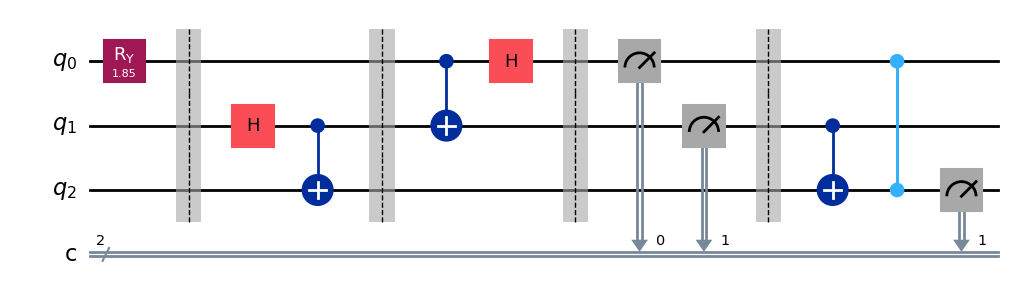

In [7]:
qc = QuantumCircuit(3,2)
theta = 2 * np.arccos(0.6)  # Calculate angle for |0> and |1> amplitude
phi = 0  # No phase for the state
qc.ry(theta, 0)
qc.barrier()
qc.draw()
qc.h(1)
qc.cx(1,2)
qc.barrier()
qc.cx(0,1)
qc.h(0)
qc.barrier()
qc.measure([0, 1], [0, 1])
qc.barrier()
qc.cx(1, 2)
qc.cz(0, 2)
qc.measure([2], [1])
qc.draw('mpl')

# Simulating Run on AER Simulator

In [8]:
# Set up the simulator backend
aer_sim = Aer.get_backend('aer_simulator')
qobj = transpile(qc)
job = aer_sim.run(qobj, shots=1000)
hist = job.result().get_counts()
print(hist)
# Calculate probabilities by normalizing the counts
total_shots = sum(hist.values())
probabilities = {key: value / total_shots for key, value in hist.items()}
# Print the histogram and the probabilities
print("Probabilities:", probabilities)

{'11': 350, '10': 321, '01': 154, '00': 175}
Probabilities: {'11': 0.35, '10': 0.321, '01': 0.154, '00': 0.175}


# Plotting results

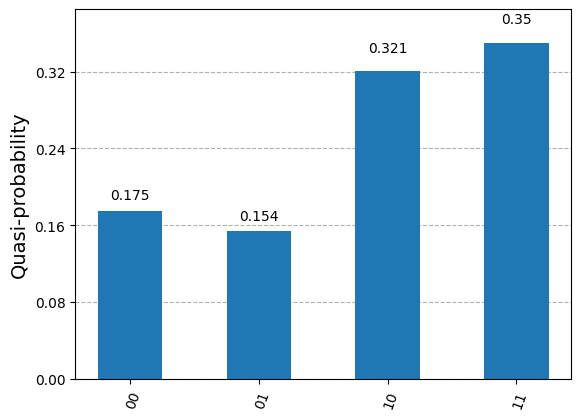

In [9]:
plot_histogram(probabilities)

## On the first bit the probability of getting 0 is 0.329 close to 36% (optimal)
## The probability of getting 1 is 0.671 close 64%(optimal)

# Circuit for Running on Quantum Hardware

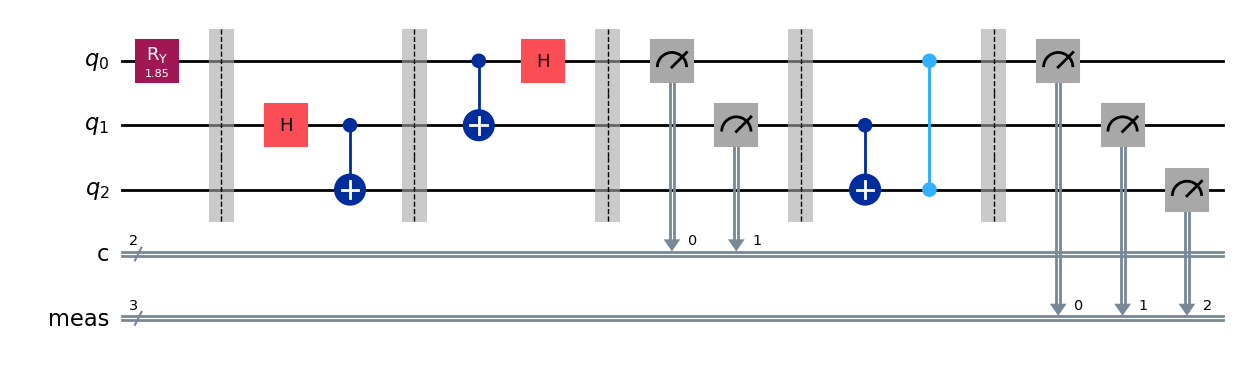

In [ ]:
from qiskit_ibm_runtime import SamplerV2 as Sampler
# Define a real backend
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False)

from qiskit import QuantumCircuit

qc = QuantumCircuit(3,2)
theta = 2 * np.arccos(0.6)  # Calculate angle for |0> and |1> amplitude
phi = 0  # No phase for the state
qc.ry(theta, 0)
qc.barrier()
qc.draw()
qc.h(1)
qc.cx(1,2)
qc.barrier()
qc.cx(0,1)
qc.h(0)
qc.barrier()
qc.measure([0, 1], [0, 1])
qc.barrier()
qc.cx(1, 2)
qc.cz(0, 2)
qc.measure_all()
qc.draw('mpl')


# Optimizing circuit to run on Quantum Hardware

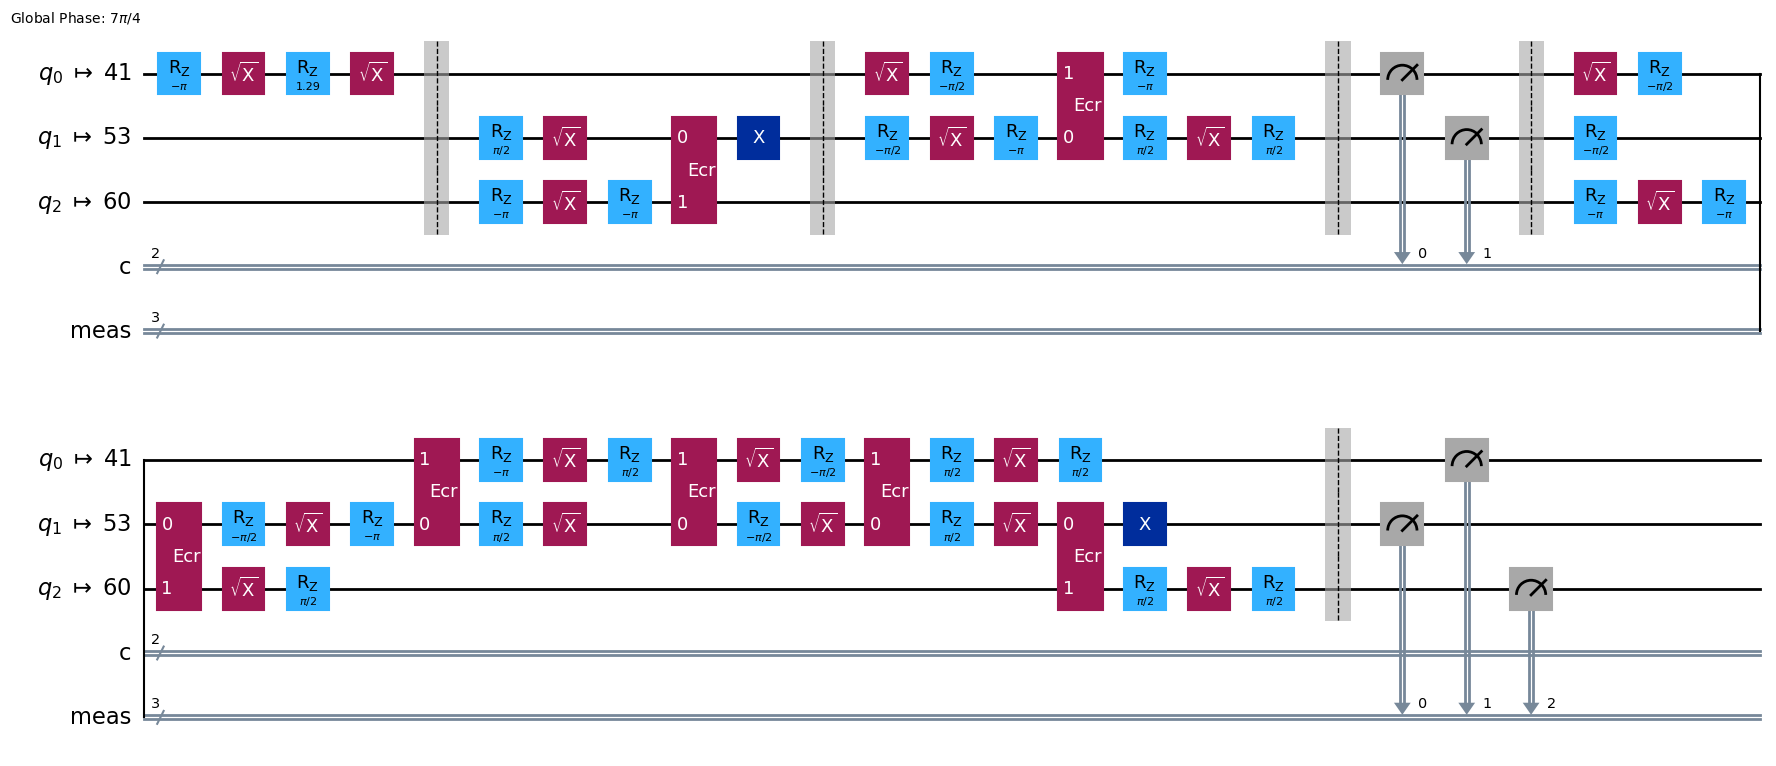

In [11]:
# Circuits must obey the ISA of the backend.
# Convert to ISA circuits
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
 
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)
isa_circuit.draw("mpl", idle_wires=False)

In [12]:
sampler = Sampler(mode=backend)
 
job = sampler.run([isa_circuit])
 
result = job.result()
# Get results for the first (and only) PUB
pub_result = result[0]
 
# Get counts from the classical register "meas".
print(f" >> Meas output register counts: {pub_result.data.meas.get_counts()}")

 >> Meas output register counts: {'111': 631, '010': 327, '101': 629, '000': 404, '100': 704, '011': 364, '001': 359, '110': 678}


In [13]:
counts=pub_result.data.meas.get_counts()

In [14]:
counts

{'111': 631,
 '010': 327,
 '101': 629,
 '000': 404,
 '100': 704,
 '011': 364,
 '001': 359,
 '110': 678}

# Plotting results

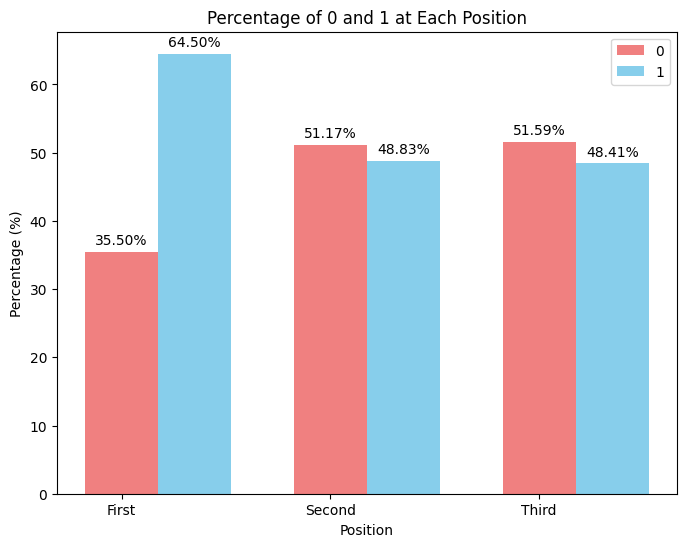

In [15]:
# Initialize counters for 0 and 1 at each position
count_0 = [0, 0, 0]  # Count of '0' at positions 1st, 2nd, and 3rd
count_1 = [0, 0, 0]  # Count of '1' at positions 1st, 2nd, and 3rd
total_counts = [0, 0, 0]  # Total counts for each position

# Go through the patterns and update the counts
for pattern, count in counts.items():
    for i, digit in enumerate(pattern):
        if digit == '0':
            count_0[i] += count
        else:
            count_1[i] += count
        total_counts[i] += count

# Calculate percentage for 0 and 1 at each position
percentage_0 = [c / total * 100 for c, total in zip(count_0, total_counts)]
percentage_1 = [c / total * 100 for c, total in zip(count_1, total_counts)]

# Plotting the bar plot
positions = ['First', 'Second', 'Third']
width = 0.35  # Bar width for grouping '0' and '1'

fig, ax = plt.subplots(figsize=(8, 6))
bar_0 = ax.bar(positions, percentage_0, width, label='0', color='lightcoral')
bar_1 = ax.bar([p + width for p in range(len(positions))], percentage_1, width, label='1', color='skyblue')

# Adding labels and title
ax.set_xlabel('Position')
ax.set_ylabel('Percentage (%)')
ax.set_title('Percentage of 0 and 1 at Each Position')
ax.legend()

# Annotate the bars with the percentage values
for i, (bar_0_val, bar_1_val) in enumerate(zip(bar_0, bar_1)):
    ax.annotate(f'{percentage_0[i]:.2f}%', 
                (bar_0_val.get_x() + bar_0_val.get_width() / 2, bar_0_val.get_height()),
                textcoords="offset points", xytext=(0, 5), ha='center', fontsize=10, color='black')
    ax.annotate(f'{percentage_1[i]:.2f}%', 
                (bar_1_val.get_x() + bar_1_val.get_width() / 2, bar_1_val.get_height()),
                textcoords="offset points", xytext=(0, 5), ha='center', fontsize=10, color='black')

plt.show()

## For the first bit after teleportation First bit probability is 35.50%
## Second bit probability is 64.50%

### The noise is significantly low in the IBM Quantum Device and therefore our results are much closer to the ones we should get optimally